In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


################################################################################
# Attention Residual U-Net (Attention ResUNet)
################################################################################

# 1. Convolutional Block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

# 2. Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        
        # Shortcut if input and output channels differ
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

# 3. Upsampling Block
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
    def forward(self, x):
        return self.up(x)

# 4. Attention Block
class AttentionBlock(nn.Module):
    """
    The AttentionBlock computes an attention coefficient for a gating signal (g) and a skip
    connection (x), then applies it to x. This is based on the "Attention U-Net" paper.
    """
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        
        # First set of 1x1 convolutions
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int),
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int),
        )
        
        # Psi (ψ) to generate attention map
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid(),
        )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # g is the gating signal, x is the skip connection
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        
        return x * psi

# 5. Attention Residual U-Net Model
class AttentionResUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(AttentionResUNet, self).__init__()
        
        # ----------------- Encoder -----------------
        self.enc1 = ConvBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ResidualBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ResidualBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # ----------------- Bridge -----------------
        self.bridge = ConvBlock(512, 1024)
        
        # ----------------- Decoder -----------------
        # (Gating signal is typically the up-sampled feature from a deeper layer)
        self.up4 = UpConv(1024, 512)
        self.att4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.dec4 = ResidualBlock(1024, 512)

        self.up3 = UpConv(512, 256)
        self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = UpConv(256, 128)
        self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.dec2 = ResidualBlock(256, 128)

        self.up1 = UpConv(128, 64)
        self.att1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.dec1 = ConvBlock(128, 64)
        
        # ----------------- Output -----------------
        self.final = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bridge
        b  = self.bridge(self.pool4(e4))

        # Decoder level 4
        d4_up = self.up4(b)
        e4_att = self.att4(d4_up, e4)
        d4 = torch.cat((e4_att, d4_up), dim=1)
        d4 = self.dec4(d4)
        
        # Decoder level 3
        d3_up = self.up3(d4)
        e3_att = self.att3(d3_up, e3)
        d3 = torch.cat((e3_att, d3_up), dim=1)
        d3 = self.dec3(d3)
        
        # Decoder level 2
        d2_up = self.up2(d3)
        e2_att = self.att2(d2_up, e2)
        d2 = torch.cat((e2_att, d2_up), dim=1)
        d2 = self.dec2(d2)
        
        # Decoder level 1
        d1_up = self.up1(d2)
        e1_att = self.att1(d1_up, e1)
        d1 = torch.cat((e1_att, d1_up), dim=1)
        d1 = self.dec1(d1)

        # Final
        out = self.final(d1)
        return out

Using device: cuda
Loading data...


100%|██████████| 110/110 [00:02<00:00, 39.77it/s]


Train: 2751, Validation: 589, Test: 589


Epoch 1/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.36it/s]


Epoch 1/100 - Train Loss: 0.6720, Train Dice: 0.9712, Val Loss: 0.6370, Val Dice: 0.9555
Saved best model with validation loss: 0.6370


Epoch 2/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.55it/s]


Epoch 2/100 - Train Loss: 0.6082, Train Dice: 0.9562, Val Loss: 0.5890, Val Dice: 0.9460
Saved best model with validation loss: 0.5890


Epoch 3/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.58it/s]


Epoch 3/100 - Train Loss: 0.5738, Train Dice: 0.9439, Val Loss: 0.5565, Val Dice: 0.9349
Saved best model with validation loss: 0.5565


Epoch 4/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.50it/s]


Epoch 4/100 - Train Loss: 0.5473, Train Dice: 0.9310, Val Loss: 0.5306, Val Dice: 0.9250
Saved best model with validation loss: 0.5306


Epoch 5/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.50it/s]


Epoch 5/100 - Train Loss: 0.5224, Train Dice: 0.9127, Val Loss: 0.5065, Val Dice: 0.8934
Saved best model with validation loss: 0.5065


Epoch 6/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.20it/s]


Epoch 6/100 - Train Loss: 0.4970, Train Dice: 0.8865, Val Loss: 0.4834, Val Dice: 0.8561
Saved best model with validation loss: 0.4834


Epoch 7/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.36it/s]


Epoch 7/100 - Train Loss: 0.4641, Train Dice: 0.8434, Val Loss: 0.4643, Val Dice: 0.8260
Saved best model with validation loss: 0.4643


Epoch 8/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.25it/s]


Epoch 8/100 - Train Loss: 0.4294, Train Dice: 0.7917, Val Loss: 0.4174, Val Dice: 0.7816
Saved best model with validation loss: 0.4174


Epoch 9/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.22it/s]


Epoch 9/100 - Train Loss: 0.3917, Train Dice: 0.7298, Val Loss: 0.3702, Val Dice: 0.6929
Saved best model with validation loss: 0.3702


Epoch 10/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.46it/s]


Epoch 10/100 - Train Loss: 0.3488, Train Dice: 0.6547, Val Loss: 0.3728, Val Dice: 0.7074
EarlyStopping counter: 1 out of 10


Epoch 11/100 (Validation): 100%|██████████| 85/85 [00:06<00:00, 13.96it/s]


Epoch 11/100 - Train Loss: 0.3106, Train Dice: 0.5848, Val Loss: 0.3129, Val Dice: 0.5987
Saved best model with validation loss: 0.3129


Epoch 12/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 14.67it/s]


Epoch 12/100 - Train Loss: 0.2632, Train Dice: 0.4959, Val Loss: 0.2723, Val Dice: 0.5205
Saved best model with validation loss: 0.2723


Epoch 13/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.20it/s]


Epoch 13/100 - Train Loss: 0.2369, Train Dice: 0.4456, Val Loss: 0.2375, Val Dice: 0.4509
Saved best model with validation loss: 0.2375


Epoch 14/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.54it/s]


Epoch 14/100 - Train Loss: 0.2174, Train Dice: 0.4073, Val Loss: 0.2104, Val Dice: 0.3984
Saved best model with validation loss: 0.2104


Epoch 15/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.57it/s]


Epoch 15/100 - Train Loss: 0.1908, Train Dice: 0.3566, Val Loss: 0.2359, Val Dice: 0.4486
EarlyStopping counter: 1 out of 10


Epoch 16/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.54it/s]


Epoch 16/100 - Train Loss: 0.1832, Train Dice: 0.3418, Val Loss: 0.1890, Val Dice: 0.3583
Saved best model with validation loss: 0.1890


Epoch 17/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.52it/s]


Epoch 17/100 - Train Loss: 0.1731, Train Dice: 0.3222, Val Loss: 0.1821, Val Dice: 0.3456
Saved best model with validation loss: 0.1821


Epoch 18/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.56it/s]


Epoch 18/100 - Train Loss: 0.1577, Train Dice: 0.2927, Val Loss: 0.1883, Val Dice: 0.3577
EarlyStopping counter: 1 out of 10


Epoch 19/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.65it/s]


Epoch 19/100 - Train Loss: 0.1525, Train Dice: 0.2827, Val Loss: 0.1728, Val Dice: 0.3262
Saved best model with validation loss: 0.1728


Epoch 20/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.50it/s]


Epoch 20/100 - Train Loss: 0.1614, Train Dice: 0.2993, Val Loss: 0.1858, Val Dice: 0.3511
EarlyStopping counter: 1 out of 10


Epoch 21/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.57it/s]


Epoch 21/100 - Train Loss: 0.1598, Train Dice: 0.2949, Val Loss: 0.1714, Val Dice: 0.3241
Saved best model with validation loss: 0.1714


Epoch 22/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.51it/s]


Epoch 22/100 - Train Loss: 0.1457, Train Dice: 0.2681, Val Loss: 0.1657, Val Dice: 0.3129
Saved best model with validation loss: 0.1657


Epoch 23/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.57it/s]


Epoch 23/100 - Train Loss: 0.1405, Train Dice: 0.2587, Val Loss: 0.1719, Val Dice: 0.3242
EarlyStopping counter: 1 out of 10


Epoch 24/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.60it/s]


Epoch 24/100 - Train Loss: 0.1274, Train Dice: 0.2342, Val Loss: 0.1621, Val Dice: 0.3059
Saved best model with validation loss: 0.1621


Epoch 25/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.56it/s]


Epoch 25/100 - Train Loss: 0.1290, Train Dice: 0.2373, Val Loss: 0.1585, Val Dice: 0.2983
Saved best model with validation loss: 0.1585


Epoch 26/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.50it/s]


Epoch 26/100 - Train Loss: 0.1235, Train Dice: 0.2274, Val Loss: 0.1648, Val Dice: 0.3120
EarlyStopping counter: 1 out of 10


Epoch 27/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.58it/s]


Epoch 27/100 - Train Loss: 0.1205, Train Dice: 0.2213, Val Loss: 0.1601, Val Dice: 0.2992
EarlyStopping counter: 2 out of 10


Epoch 28/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.56it/s]


Epoch 28/100 - Train Loss: 0.1206, Train Dice: 0.2220, Val Loss: 0.1445, Val Dice: 0.2708
Saved best model with validation loss: 0.1445


Epoch 29/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.56it/s]


Epoch 29/100 - Train Loss: 0.1132, Train Dice: 0.2077, Val Loss: 0.1931, Val Dice: 0.3639
EarlyStopping counter: 1 out of 10


Epoch 30/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.55it/s]


Epoch 30/100 - Train Loss: 0.1185, Train Dice: 0.2178, Val Loss: 0.1411, Val Dice: 0.2658
Saved best model with validation loss: 0.1411


Epoch 31/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.57it/s]


Epoch 31/100 - Train Loss: 0.1206, Train Dice: 0.2217, Val Loss: 0.1614, Val Dice: 0.3043
EarlyStopping counter: 1 out of 10


Epoch 32/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.66it/s]


Epoch 32/100 - Train Loss: 0.1077, Train Dice: 0.1972, Val Loss: 0.1467, Val Dice: 0.2756
EarlyStopping counter: 2 out of 10


Epoch 33/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.58it/s]


Epoch 33/100 - Train Loss: 0.1079, Train Dice: 0.1987, Val Loss: 0.1448, Val Dice: 0.2724
EarlyStopping counter: 3 out of 10


Epoch 34/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.58it/s]


Epoch 34/100 - Train Loss: 0.1041, Train Dice: 0.1911, Val Loss: 0.1524, Val Dice: 0.2876
EarlyStopping counter: 4 out of 10


Epoch 35/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.61it/s]


Epoch 35/100 - Train Loss: 0.1093, Train Dice: 0.2002, Val Loss: 0.1657, Val Dice: 0.3125
EarlyStopping counter: 5 out of 10


Epoch 36/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.56it/s]


Epoch 36/100 - Train Loss: 0.1087, Train Dice: 0.1997, Val Loss: 0.1385, Val Dice: 0.2620
Saved best model with validation loss: 0.1385


Epoch 37/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.43it/s]


Epoch 37/100 - Train Loss: 0.1059, Train Dice: 0.1939, Val Loss: 0.1733, Val Dice: 0.3240
EarlyStopping counter: 1 out of 10


Epoch 38/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.59it/s]


Epoch 38/100 - Train Loss: 0.1026, Train Dice: 0.1878, Val Loss: 0.1373, Val Dice: 0.2594
Saved best model with validation loss: 0.1373


Epoch 39/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.55it/s]


Epoch 39/100 - Train Loss: 0.0982, Train Dice: 0.1796, Val Loss: 0.1363, Val Dice: 0.2575
Saved best model with validation loss: 0.1363


Epoch 40/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.53it/s]


Epoch 40/100 - Train Loss: 0.1089, Train Dice: 0.1991, Val Loss: 0.1582, Val Dice: 0.2978
EarlyStopping counter: 1 out of 10


Epoch 41/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.57it/s]


Epoch 41/100 - Train Loss: 0.0984, Train Dice: 0.1796, Val Loss: 0.1586, Val Dice: 0.2985
EarlyStopping counter: 2 out of 10


Epoch 42/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.64it/s]


Epoch 42/100 - Train Loss: 0.1031, Train Dice: 0.1889, Val Loss: 0.1363, Val Dice: 0.2570
EarlyStopping counter: 3 out of 10


Epoch 43/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.57it/s]


Epoch 43/100 - Train Loss: 0.0957, Train Dice: 0.1750, Val Loss: 0.1395, Val Dice: 0.2635
EarlyStopping counter: 4 out of 10


Epoch 44/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.60it/s]


Epoch 44/100 - Train Loss: 0.0981, Train Dice: 0.1790, Val Loss: 0.1534, Val Dice: 0.2894
EarlyStopping counter: 5 out of 10


Epoch 45/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.52it/s]


Epoch 45/100 - Train Loss: 0.0925, Train Dice: 0.1693, Val Loss: 0.1392, Val Dice: 0.2627
EarlyStopping counter: 6 out of 10


Epoch 46/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.57it/s]


Epoch 46/100 - Train Loss: 0.1038, Train Dice: 0.1903, Val Loss: 0.1548, Val Dice: 0.2917
EarlyStopping counter: 7 out of 10


Epoch 47/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.64it/s]


Epoch 47/100 - Train Loss: 0.0921, Train Dice: 0.1690, Val Loss: 0.1502, Val Dice: 0.2825
EarlyStopping counter: 8 out of 10


Epoch 48/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.56it/s]


Epoch 48/100 - Train Loss: 0.0891, Train Dice: 0.1630, Val Loss: 0.1286, Val Dice: 0.2420
Saved best model with validation loss: 0.1286


Epoch 49/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.59it/s]


Epoch 49/100 - Train Loss: 0.0912, Train Dice: 0.1670, Val Loss: 0.1504, Val Dice: 0.2836
EarlyStopping counter: 1 out of 10


Epoch 50/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.55it/s]


Epoch 50/100 - Train Loss: 0.0884, Train Dice: 0.1614, Val Loss: 0.1283, Val Dice: 0.2408
Saved best model with validation loss: 0.1283


Epoch 51/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.55it/s]


Epoch 51/100 - Train Loss: 0.0902, Train Dice: 0.1650, Val Loss: 0.1249, Val Dice: 0.2351
Saved best model with validation loss: 0.1249


Epoch 52/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.65it/s]


Epoch 52/100 - Train Loss: 0.0937, Train Dice: 0.1719, Val Loss: 0.1486, Val Dice: 0.2792
EarlyStopping counter: 1 out of 10


Epoch 53/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.62it/s]


Epoch 53/100 - Train Loss: 0.0977, Train Dice: 0.1789, Val Loss: 0.1491, Val Dice: 0.2807
EarlyStopping counter: 2 out of 10


Epoch 54/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.41it/s]


Epoch 54/100 - Train Loss: 0.0925, Train Dice: 0.1696, Val Loss: 0.1247, Val Dice: 0.2350
Saved best model with validation loss: 0.1247


Epoch 55/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.54it/s]


Epoch 55/100 - Train Loss: 0.1014, Train Dice: 0.1853, Val Loss: 0.1361, Val Dice: 0.2570
EarlyStopping counter: 1 out of 10


Epoch 56/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.60it/s]


Epoch 56/100 - Train Loss: 0.0977, Train Dice: 0.1790, Val Loss: 0.1311, Val Dice: 0.2466
EarlyStopping counter: 2 out of 10


Epoch 57/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.63it/s]


Epoch 57/100 - Train Loss: 0.0906, Train Dice: 0.1658, Val Loss: 0.1243, Val Dice: 0.2343
Saved best model with validation loss: 0.1243


Epoch 58/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.56it/s]


Epoch 58/100 - Train Loss: 0.0894, Train Dice: 0.1644, Val Loss: 0.1450, Val Dice: 0.2723
EarlyStopping counter: 1 out of 10


Epoch 59/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.55it/s]


Epoch 59/100 - Train Loss: 0.0804, Train Dice: 0.1466, Val Loss: 0.1218, Val Dice: 0.2289
Saved best model with validation loss: 0.1218


Epoch 60/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.60it/s]


Epoch 60/100 - Train Loss: 0.0864, Train Dice: 0.1575, Val Loss: 0.1249, Val Dice: 0.2345
EarlyStopping counter: 1 out of 10


Epoch 61/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.62it/s]


Epoch 61/100 - Train Loss: 0.0964, Train Dice: 0.1763, Val Loss: 0.1381, Val Dice: 0.2595
EarlyStopping counter: 2 out of 10


Epoch 62/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.59it/s]


Epoch 62/100 - Train Loss: 0.0937, Train Dice: 0.1715, Val Loss: 0.1321, Val Dice: 0.2480
EarlyStopping counter: 3 out of 10


Epoch 63/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.60it/s]


Epoch 63/100 - Train Loss: 0.0955, Train Dice: 0.1758, Val Loss: 0.1332, Val Dice: 0.2505
EarlyStopping counter: 4 out of 10


Epoch 64/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.51it/s]


Epoch 64/100 - Train Loss: 0.0856, Train Dice: 0.1567, Val Loss: 0.1438, Val Dice: 0.2701
EarlyStopping counter: 5 out of 10


Epoch 65/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.52it/s]


Epoch 65/100 - Train Loss: 0.0919, Train Dice: 0.1681, Val Loss: 0.1253, Val Dice: 0.2359
EarlyStopping counter: 6 out of 10


Epoch 66/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.57it/s]


Epoch 66/100 - Train Loss: 0.0811, Train Dice: 0.1479, Val Loss: 0.1382, Val Dice: 0.2611
EarlyStopping counter: 7 out of 10


Epoch 67/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.55it/s]


Epoch 67/100 - Train Loss: 0.0791, Train Dice: 0.1447, Val Loss: 0.1537, Val Dice: 0.2864
EarlyStopping counter: 8 out of 10


Epoch 68/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.53it/s]


Epoch 68/100 - Train Loss: 0.0856, Train Dice: 0.1572, Val Loss: 0.1284, Val Dice: 0.2414
EarlyStopping counter: 9 out of 10


Epoch 69/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.51it/s]


Epoch 69/100 - Train Loss: 0.1241, Train Dice: 0.2275, Val Loss: 0.1374, Val Dice: 0.2594
EarlyStopping counter: 10 out of 10
Early stopping triggered


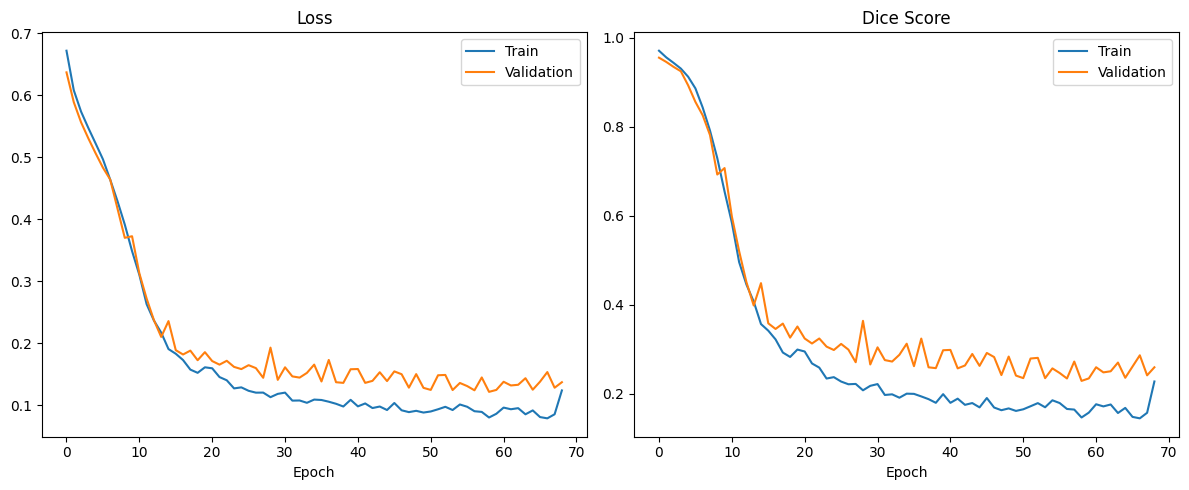

Evaluating: 100%|██████████| 589/589 [00:04<00:00, 143.81it/s]


Test Dice Score: 0.8964


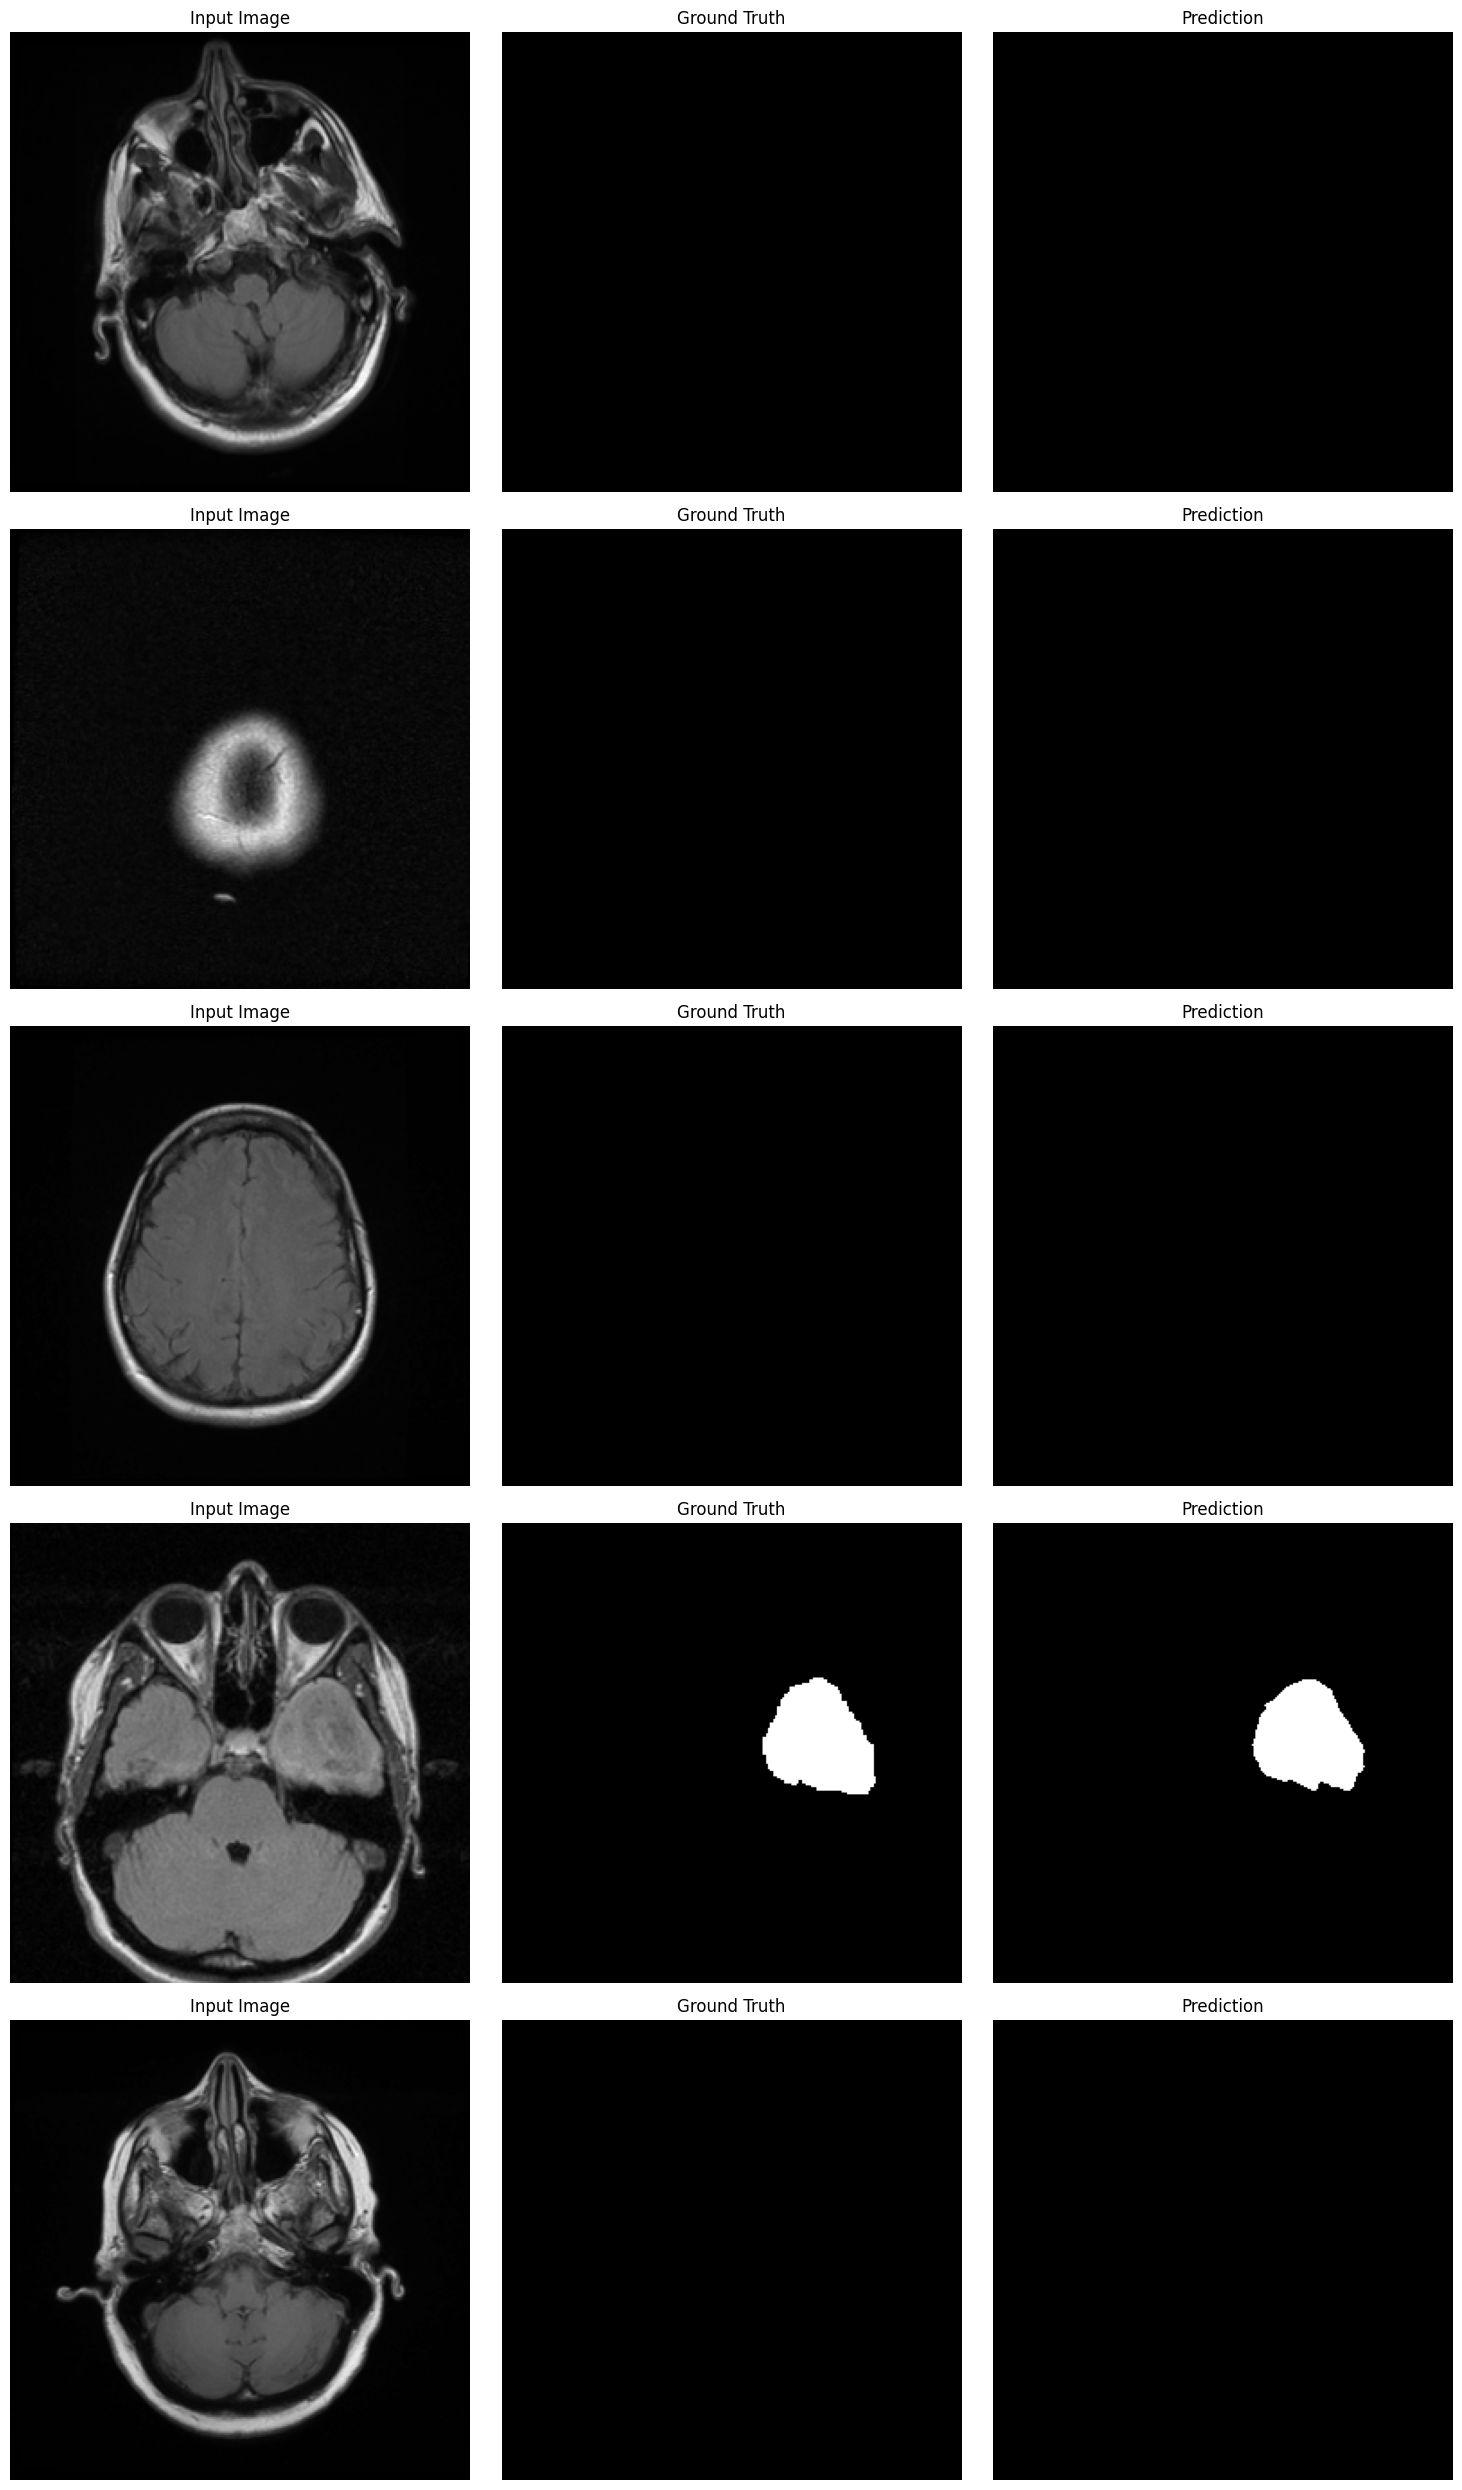

In [2]:
from segmentation import run_segmentation_pipeline

my_model = AttentionResUNet(in_channels=1, out_channels=1)

# Run the pipeline with custom model and naming
trained_model, dice_score = run_segmentation_pipeline(
    model=my_model,
    base_dir="kaggle_3m",
    model_name="Attresunet",
    batch_size=7,
    patience=10
)